In [313]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import gc #garbage collector
import sys
import os
from pandas.api.types import CategoricalDtype
#from xgboost import XGBRegressor as xgb
import xgboost as xgb
from itertools import product
from statistics import stdev 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from datetime import date
import pickle
import pyodbc
import time
from tqdm import tqdm
import copy
from pathlib import Path
import datetime
from datetime import date
from xgboost import XGBRegressor
from dateutil.relativedelta import *
from pandas import ExcelWriter
from sklearn2pmml import sklearn2pmml
from sklearn_pandas import DataFrameMapper
from sklearn2pmml import PMMLPipeline
from sklearn2pmml import Pipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn2pmml.decoration import CategoricalDomain, ContinuousDomain
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn2pmml.preprocessing.xgboost import make_xgboost_column_transformer
from sklearn.pipeline import Pipeline
from sklearn2pmml.preprocessing import PMMLLabelEncoder
from sklearn2pmml import make_pmml_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools


In [314]:
df = pd.read_csv('CKD_Preprocessed.csv')

#Declare feature vector and target variable
X = df.drop('Chronic Kidney Disease: yes', axis=1)
y = df['Chronic Kidney Disease: yes']

In [315]:
#df = pd.read_csv('kidney_disease_model_data.csv')
#df = df.drop(columns = ['Unnamed: 0' , 'id'])

#Declare feature vector and target variable
#X = df.drop('classification', axis=1)

#y = df['classification']

In [316]:
#Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [317]:
#Split data into separate training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## XGBClassifier

In [318]:
# import XGBClassifier
from xgboost import XGBClassifier

# declare parameters
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100
        }
                       
# instantiate the classifier 
xgb_clf = XGBClassifier(**params)

# fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=1.0, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=10, ...)

In [319]:
y_pred = xgb_clf.predict(X_test)

In [320]:
from sklearn.metrics import accuracy_score

print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

XGBoost model accuracy score: 1.0000


In [321]:
from xgboost import cv

params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

In [322]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.94,0.01,0.94,0.02
1,0.99,0.01,0.99,0.01
2,1.00,0.00,1.00,0.00
3,1.00,0.00,1.00,0.00
4,1.00,0.00,1.00,0.00


In [323]:
importance_data = sorted(list(zip(X_test.columns,xgb_clf.feature_importances_)),key=lambda tpl:tpl[1],reverse=True)

In [324]:
importance_data

[('Hemoglobin (gms)', 0.7281681),
 ('Specific Gravity', 0.2561611),
 ('Serum Creatinine (mgs/dL)', 0.015670842),
 ('Age (yrs)', 0.0),
 ('Blood Pressure (mm/Hg)', 0.0),
 ('Albumin', 0.0),
 ('Sugar', 0.0),
 ('Blood Glucose Random (mgs/dL)', 0.0),
 ('Blood Urea (mgs/dL)', 0.0),
 ('Sodium (mEq/L)', 0.0),
 ('Potassium (mEq/L)', 0.0),
 ('Packed Cell Volume', 0.0),
 ('White Blood Cells (cells/cmm)', 0.0),
 ('Red Blood Cells (millions/cmm)', 0.0),
 ('Red Blood Cells: normal', 0.0),
 ('Pus Cells: normal', 0.0),
 ('Pus Cell Clumps: present', 0.0),
 ('Bacteria: present', 0.0),
 ('Hypertension: yes', 0.0),
 ('Diabetes Mellitus: yes', 0.0),
 ('Coronary Artery Disease: yes', 0.0),
 ('Appetite: poor', 0.0),
 ('Pedal Edema: yes', 0.0),
 ('Anemia: yes', 0.0)]

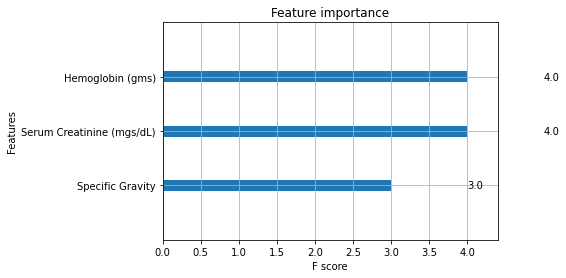

In [325]:
xgb.plot_importance(xgb_clf)
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

In [326]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)

In [327]:
auc_score = metrics.auc(fpr, tpr)

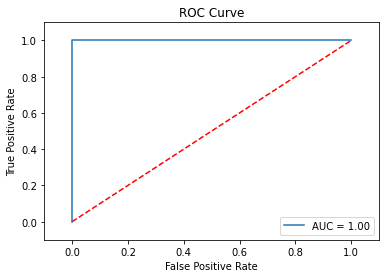

In [328]:
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## ADABoostClassifier

In [329]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

In [330]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


In [331]:
importance_data = sorted(list(zip(X_test.columns,abc.feature_importances_)),key=lambda tpl:tpl[1],reverse=True)

In [358]:
importance_data

[('Hemoglobin (gms)', 0.26844131466363935),
 ('Specific Gravity', 0.13828290328195994),
 ('Serum Creatinine (mgs/dL)', 0.12989670816093662),
 ('Packed Cell Volume', 0.1258193714077765),
 ('Albumin', 0.060567671440125564),
 ('Red Blood Cells (millions/cmm)', 0.052612165244222416),
 ('Hypertension: yes', 0.04986806012574671),
 ('Diabetes Mellitus: yes', 0.036981982544270244),
 ('Blood Glucose Random (mgs/dL)', 0.02576950370519584),
 ('Sodium (mEq/L)', 0.025612237983595618),
 ('Blood Urea (mgs/dL)', 0.019387787641382555),
 ('Appetite: poor', 0.01405968396835547),
 ('Sugar', 0.008847394783588257),
 ('Age (yrs)', 0.00831132638334332),
 ('Potassium (mEq/L)', 0.007890146891535017),
 ('Blood Pressure (mm/Hg)', 0.007849314362964425),
 ('Pedal Edema: yes', 0.005577684913445431),
 ('Red Blood Cells: normal', 0.005126812444138021),
 ('White Blood Cells (cells/cmm)', 0.004323899753345187),
 ('Pus Cells: normal', 0.002843042999212536),
 ('Anemia: yes', 0.0012819738017402506),
 ('Pus Cell Clumps: pre

In [332]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)

In [333]:
auc_score = metrics.auc(fpr, tpr)

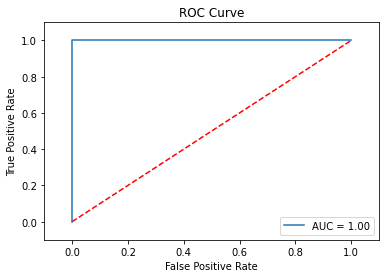

In [334]:
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## RANDOM FOREST Classifier 

In [335]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [336]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


In [337]:
importance_data = sorted(list(zip(X_test.columns,clf.feature_importances_)),key=lambda tpl:tpl[1],reverse=True)

In [338]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)

In [339]:
auc_score = metrics.auc(fpr, tpr)

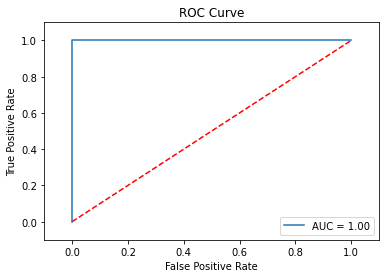

In [340]:
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## Logistic Regression

In [341]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=16)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

In [342]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[45,  3],
       [ 6, 66]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

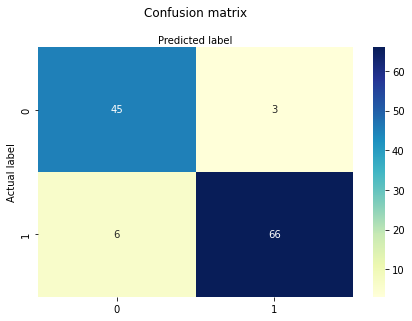

In [343]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [344]:
from sklearn.metrics import classification_report
target_names = ['Not CKD', 'CKD']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Not CKD       0.88      0.94      0.91        48
         CKD       0.96      0.92      0.94        72

    accuracy                           0.93       120
   macro avg       0.92      0.93      0.92       120
weighted avg       0.93      0.93      0.93       120



In [345]:
print('Logistic Regression model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Logistic Regression model accuracy score: 0.9250


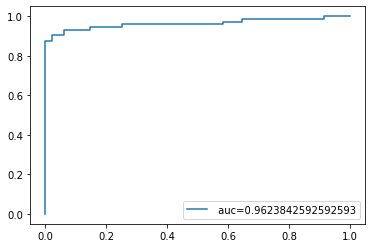

In [346]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label=" auc="+str(auc))
plt.legend(loc=4)
plt.show()

##  Support Vector Machines

In [347]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [348]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.95


In [349]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.9852941176470589
Recall: 0.9305555555555556


In [350]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[47,  1],
       [ 5, 67]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

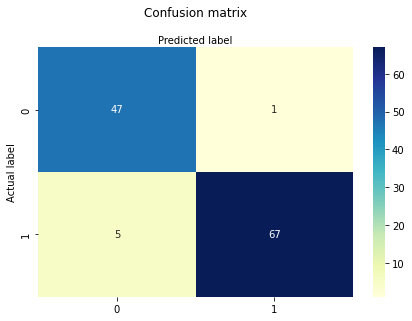

In [351]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

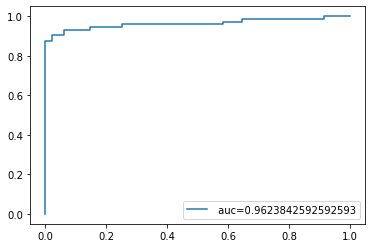

In [352]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label=" auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Naive Bayes Classifier

In [353]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_test)

In [354]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.975


In [355]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[48,  0],
       [ 3, 69]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

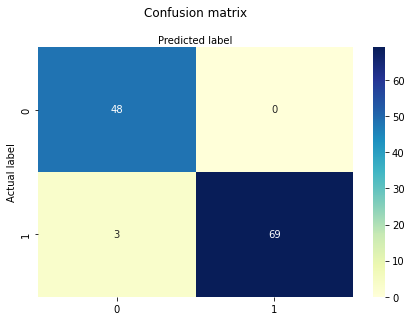

In [356]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

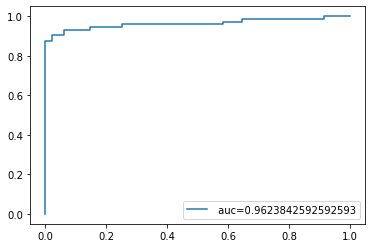

In [357]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label=" auc="+str(auc))
plt.legend(loc=4)
plt.show()